# Deep Learning
## HW2 - Problem 2

1.   Full Name: Amir Mohammad Yaghoobian zadeh
2.   Student Number: 401300525

In [121]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn
import pandas as pd
from google.colab import drive
import torch
from torchvision import datasets
from torchvision.transforms import ToTensor, Lambda
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

from google.colab import drive
drive.mount('/content/gdrive')


Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


#part A

In [122]:
plays = pd.read_csv('gdrive/MyDrive/Deep learning/HW2/Data/HW2_data/international_matches.csv')
display(plays[-10:])

,date,home_team,away_team,home_team_continent,away_team_continent,home_team_fifa_rank,away_team_fifa_rank,home_team_total_fifa_points,away_team_total_fifa_points,home_team_score,...,shoot_out,home_team_result,home_team_goalkeeper_score,away_team_goalkeeper_score,home_team_mean_defense_score,home_team_mean_offense_score,home_team_mean_midfield_score,away_team_mean_defense_score,away_team_mean_offense_score,away_team_mean_midfield_score
23911,2022-06-14,Ukraine,Republic of Ireland,Europe,Europe,27,47,1535,1449,1,...,No,Draw,75.0,75.0,74.8,78.7,80.0,76.5,72.7,73.8
23912,2022-06-14,Bosnia and Herzegovina,Finland,Europe,Europe,59,57,1388,1406,3,...,No,Win,76.0,83.0,74.2,77.0,78.0,70.0,72.3,73.5
23913,2022-06-14,Romania,Montenegro,Europe,Europe,48,70,1446,1342,0,...,No,Lose,77.0,65.0,73.5,73.7,75.0,76.2,74.7,68.2
23914,2022-06-14,Luxembourg,Faroe Islands,Europe,Europe,94,124,1229,1137,2,...,No,Draw,69.0,NaN,68.5,NaN,69.8,NaN,NaN,NaN
23915,2022-06-14,Turkey,Lithuania,Europe,Europe,43,138,1461,1092,2,...,No,Win,79.0,71.0,78.2,76.7,78.2,NaN,NaN,NaN
23916,2022-06-14,Moldova,Andorra,Europe,Europe,180,153,932,1040,2,...,No,Win,65.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
23917,2022-06-14,Liechtenstein,Latvia,Europe,Europe,192,135,895,1105,0,...,No,Lose,NaN,65.0,NaN,NaN,NaN,NaN,NaN,NaN
23918,2022-06-14,Chile,Ghana,South America,Africa,28,60,1526,1387,0,...,Yes,Lose,79.0,74.0,75.5,76.7,78.2,75.5,76.0,78.2
23919,2022-06-14,Japan,Tunisia,Asia,Africa,23,35,1553,1499,0,...,No,Lose,73.0,NaN,75.2,75.0,77.5,70.8,72.3,74.0
23920,2022-06-14,Korea Republic,Egypt,Asia,Africa,29,32,1519,1500,4,...,No,Win,75.0,NaN,73.0,80.0,73.8,NaN,79.3,70.8


#part B

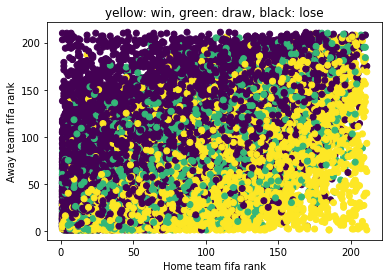

In [123]:
temp = np.zeros(plays['home_team_result'].shape)
temp[plays['home_team_result']=='win'] = 1
temp[plays['home_team_result']=='Draw'] = 2
temp[plays['home_team_result']=='Lose'] = 3

plt.scatter(plays['home_team_fifa_rank'], plays['away_team_fifa_rank'], c=temp)
plt.xlabel('Home team fifa rank')
plt.ylabel('Away team fifa rank')
plt.title('yellow: win, green: draw, black: lose')
plt.show()

#part C

In [142]:
class MY_Dataset(Dataset):
    def __init__(self, Data, transform=None, augment=False):
        if augment:
          temp = Data['home_team_result']
          win = temp=='Win'
          lose = temp=='Lose'
          temp[win] = 'Lose'
          temp[lose] = 'Win'

          temp = pd.DataFrame({'home_team_total_fifa_points': Data['away_team_total_fifa_points'], 'away_team_total_fifa_points': Data['home_team_total_fifa_points'],
                           'home_team_fifa_rank': Data['away_team_fifa_rank'], 'away_team_fifa_rank': Data['home_team_fifa_rank'], 'home_team_result': temp})
          Data = pd.concat([Data,temp]).reset_index(drop=True)

        self.Data = Data.to_numpy()
        self.transform = transform


    def __len__(self):
        return len(self.Data)

    def __getitem__(self, idx):
        feature = self.Data[idx, :-1]
        feature = torch.tensor(list(feature), dtype=torch.float32)    # convert dtype=object to dtype=float

        label = self.Data[idx, -1]
        if label=='Win':
          label = torch.tensor([1,0,0], dtype=torch.float32)
        elif label=='Draw':
          label = torch.tensor([0,1,0], dtype=torch.float32)
        elif label=='Lose':
          label = torch.tensor([0,0,1], dtype=torch.float32)

        if self.transform:
            feature = self.transform(feature)
            
        return feature, label


Data = plays[['home_team_total_fifa_points', 'away_team_total_fifa_points', 'home_team_fifa_rank', 'away_team_fifa_rank', 'home_team_result']]
Data = Data[Data['home_team_total_fifa_points'] > 0]
Data = Data[Data['away_team_total_fifa_points'] > 0]
Data = Data[Data['home_team_fifa_rank'] > 0]
Data = Data[Data['away_team_fifa_rank'] > 0]

Data = Data.sample(frac=1).reset_index(drop=True)   #shuffle the dataset
display(Data)

n_train = int(np.round(len(Data) * 0.75))

Data_train = MY_Dataset(Data.loc[:n_train-1])
Data_test = MY_Dataset(Data.loc[n_train:])
train_dataloader = DataLoader(Data_train, batch_size=64, shuffle=True)
test_dataloader = DataLoader(Data_test, batch_size=64, shuffle=True)

print(f'#train sample: {len(Data_train)}, #test sample: {len(Data_test)}')



,home_team_total_fifa_points,away_team_total_fifa_points,home_team_fifa_rank,away_team_fifa_rank,home_team_result
0,1559,1048,19,151,Win
1,1389,1143,59,123,Win
2,1350,1625,68,10,Lose
3,1074,956,139,175,Win
4,1658,1504,10,29,Win
...,...,...,...,...,...
9589,1357,1538,69,22,Lose
9590,328,695,103,41,Draw
9591,72,163,181,161,Lose
9592,1555,1433,14,41,Win


#train sample: 7196, #test sample: 2398


#part D

Feature 1: home_team_total_fifa_points
Feature 2: away_team_total_fifa_points
Feature 3: home_team_fifa_rank
Feature 4: away_team_fifa_rank

[[1.         0.94726071 0.5477969  0.64224791]
 [0.94726071 1.         0.62408778 0.56407716]
 [0.5477969  0.62408778 1.         0.85841197]
 [0.64224791 0.56407716 0.85841197 1.        ]]


Text(0.5, 1.0, 'Correlation Heat Map')

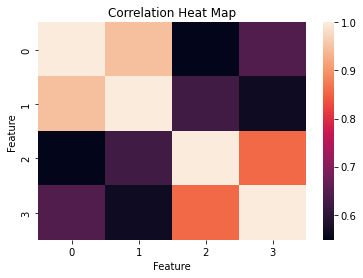

In [138]:
temp = ['home_team_total_fifa_points', 'away_team_total_fifa_points', 'home_team_fifa_rank', 'away_team_fifa_rank']
print('Feature 1: home_team_total_fifa_points\nFeature 2: away_team_total_fifa_points\nFeature 3: home_team_fifa_rank\nFeature 4: away_team_fifa_rank\n')
correlation = np.zeros((4,4))
for i in range(4):
  for j in range(4):
    correlation[i,j] = np.inner(Data[temp[i]], Data[temp[j]]) / (np.linalg.norm(Data[temp[i]], ord=2) * np.linalg.norm(Data[temp[j]], ord=2))
print(correlation)

seaborn.heatmap(correlation)
plt.xlabel('Feature')
plt.ylabel('Feature')
plt.title('Correlation Heat Map')

#part H

In [139]:
class My_NN(nn.Module):
  def __init__(self):
    super(My_NN, self).__init__()
    self.L1 = nn.Linear(4,10)
    self.L2 = nn.Linear(10,20)
    self.L3 = nn.Linear(20,8)
    self.L4 = nn.Linear(8,3)
    self.relu = nn.ReLU()
    self.softmax = nn.Softmax()
  
  def forward(self,x):
    x = self.relu(self.L1(x))
    x = self.relu(self.L2(x))
    x = self.relu(self.L3(x))
    out = self.softmax(self.L4(x))

    return out


#part V

In [143]:
def train_loop(data_loader, model, loss_func, optimizer):
  size = len(data_loader.dataset)
  num_batch = len(data_loader)

  train_loss, correct = 0, 0

  for batch ,(X,y) in enumerate(data_loader):
    pred = model(X)
    loss = loss_func(pred,y)
    train_loss += loss.item()
    correct += (pred.argmax(1) == y.argmax(1)).type(torch.float).sum().item()

    # Back propagation
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()


  train_loss /= num_batch
  correct /= size
  print(f"train error:\n Accuracy: {(100*correct):>0.1f}%, Average loss: {train_loss:>8f}")



def test_loop(data_loader, model, loss_func):
  size = len(data_loader.dataset)
  num_batch = len(data_loader)

  test_loss, correct = 0, 0

  with torch.no_grad():
    for X, y in data_loader:
        pred = model(X)
        test_loss += loss_func(pred,y).item()
        correct += (pred.argmax(1) == y.argmax(1)).type(torch.float).sum().item()

  test_loss /= num_batch
  correct /= size
  print(f"test error:\n Accuracy: {(100*correct):>0.1f}%, Average loss: {test_loss:>8f} \n")


In [145]:
learning_rate = 0.001
epochs = 200

model = My_NN()
loss_func = nn.CrossEntropyLoss(label_smoothing=0.2)
optimizer = torch.optim.RMSprop(model.parameters(),lr=learning_rate)

for epoch in range(epochs):
  print(f"Epoch: {epoch+1}")
  train_loop(train_dataloader, model, loss_func, optimizer)
  test_loop(test_dataloader, model, loss_func)


Epoch: 1


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  from ipykernel import kernelapp as app


train error:
 Accuracy: 54.1%, Average loss: 1.035852
test error:
 Accuracy: 57.6%, Average loss: 1.001603 

Epoch: 2
train error:
 Accuracy: 56.0%, Average loss: 1.009327
test error:
 Accuracy: 58.0%, Average loss: 1.004338 

Epoch: 3
train error:
 Accuracy: 56.7%, Average loss: 1.007323
test error:
 Accuracy: 57.3%, Average loss: 1.000897 

Epoch: 4
train error:
 Accuracy: 56.9%, Average loss: 1.006185
test error:
 Accuracy: 57.2%, Average loss: 1.002436 

Epoch: 5
train error:
 Accuracy: 56.9%, Average loss: 1.006195
test error:
 Accuracy: 57.5%, Average loss: 0.999819 

Epoch: 6
train error:
 Accuracy: 56.9%, Average loss: 1.005867
test error:
 Accuracy: 57.3%, Average loss: 1.001060 

Epoch: 7
train error:
 Accuracy: 57.2%, Average loss: 1.004696
test error:
 Accuracy: 57.5%, Average loss: 0.998701 

Epoch: 8
train error:
 Accuracy: 56.7%, Average loss: 1.004699
test error:
 Accuracy: 57.6%, Average loss: 0.997700 

Epoch: 9
train error:
 Accuracy: 57.0%, Average loss: 1.003980
te

#part Z

In [146]:
teams = dict({'Iran':[20,1564.61], 'England':[5,1728.47], 'USA':[16,1627.48], 'Wales':[19,1569.82]})
#Iran: rank=20, point=1564.61
#England: rank=5, point=1728.47
#USA: rank=16, point=1627.48
#Wales: rank=19, point=1569.82

results = np.zeros((4,4))

for i2,i in enumerate(teams.keys()):
  for j2,j in enumerate(teams.keys()):
    if i!=j and i2<j2:
      pred = model(torch.tensor([teams[i][1], teams[j][1], teams[i][0], teams[j][0]]))
      
      if pred.argmax()==0:
        print(i,' vs. ', j, ': Win')
      elif pred.argmax()==1:
        print(i,' vs. ', j, ': Draw')
      elif pred.argmax()==2:
        print(i,' vs. ', j, ': Lose')
      
      print(pred,'\n')

Iran  vs.  England : Lose
tensor([0.1127, 0.1030, 0.7843], grad_fn=<SoftmaxBackward0>) 

Iran  vs.  USA : Lose
tensor([0.3514, 0.1986, 0.4501], grad_fn=<SoftmaxBackward0>) 

Iran  vs.  Wales : Win
tensor([0.5789, 0.2685, 0.1526], grad_fn=<SoftmaxBackward0>) 

England  vs.  USA : Win
tensor([9.0531e-01, 9.4549e-02, 1.4358e-04], grad_fn=<SoftmaxBackward0>) 

England  vs.  Wales : Win
tensor([9.0832e-01, 9.1565e-02, 1.1740e-04], grad_fn=<SoftmaxBackward0>) 

USA  vs.  Wales : Win
tensor([8.8483e-01, 1.1476e-01, 4.1123e-04], grad_fn=<SoftmaxBackward0>) 



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  from ipykernel import kernelapp as app
